# Solving Burgers' Equation Using PINNs

### Problem Statement
We aim to solve the **Burgers' equation** using **Physics-Informed Neural Networks (PINNs)**. ### Context: What is Burgers' Equation and Why is it Useful?

The **Burgers' equation** is a fundamental partial differential equation (PDE) that appears in various fields of applied mathematics, physics, and engineering. It is expressed as:

\[
u_t + u u_x = \nu u_{xx},
\]

where:
- \( u(t, x) \) is the unknown function,
- \( u_t \) represents the temporal derivative,
- \( u_x \) is the spatial derivative,
- \( u_{xx} \) is the second spatial derivative,
- \( \nu \) is the viscosity term (a positive constant).

Burgers' equation is particularly useful because it models a wide range of physical phenomena, including **nonlinear wave propagation**, **shock waves**, **turbulence**, and **heat conduction**. It combines two key effects:
1. **Nonlinear advection** (through the \( u u_x \) term), which governs the steepening of waves.
2. **Linear diffusion** (through the \( \nu u_{xx} \) term), which smoothens sharp gradients.

This combination of effects makes Burgers' equation an important test case for studying the interplay between nonlinearity and diffusion in complex systems.

In practice, Burgers' equation is often used as a benchmark problem to validate new **numerical methods**, **machine learning techniques**, and **data-driven approaches**. Known analytical solutions for specific cases provide a reference for comparing approximate solutions, such as those computed using **Physics-Informed Neural Networks (PINNs)**. Solving Burgers' equation helps researchers explore broader phenomena in **fluid dynamics**, **traffic flow**, and **acoustic waves**, while also assessing the effectiveness of computational techniques.

The initial and boundary conditions are:

- **Initial Condition**:
  ```math
  u(0, x) = -\sin(\pi x), \quad x \in [-1, 1].
  ```
- **Boundary Conditions**:
  ```math
  u(t, -1) = u(t, 1) = 0, \quad t \in [0, 1].
  ```

The goal is to approximate \( u(t, x) \) using a PINN over the domain \( t \in [0, 1], x \in [-1, 1] \).

In [9]:
# Import required libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Neural Network Architecture
PINNs use a neural network to represent the solution \( u(t, x) \). The network takes the inputs \( t \) and \( x \) and outputs \( u(t, x) \). Here's the structure:
- Input layer: 2 features (\( t \) and \( x \))
- Hidden layers: 4 fully connected layers with 50 neurons each
- Activation function: `tanh` for all hidden layers
- Output layer: A single scalar representing \( u(t, x) \)

In [10]:
# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.input_layer = nn.Linear(2, layers[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.output_layer = nn.Linear(layers[-1], 1)
        self.activation = nn.Tanh()

    def forward(self, t, x):
        input_tensor = torch.cat([t, x], dim=1)
        input_tensor = self.activation(self.input_layer(input_tensor))
        for layer in self.hidden_layers:
            input_tensor = self.activation(layer(input_tensor))
        return self.output_layer(input_tensor)

## Physics-Informed Loss Function
The PINN minimizes two loss terms:
1. **Data Loss**:
   ```math
   \text{Loss}_u = \frac{1}{N_u} \sum_{i=1}^{N_u} \left( u_i - u_\text{pred}(t_i, x_i) \right)^2
   ```
2. **PDE Residual Loss**:
   ```math
   \text{Loss}_f = \frac{1}{N_f} \sum_{i=1}^{N_f} f(t_i, x_i)^2,
   ```
   where:
   ```math
   f(t, x) = u_t + u u_x - \nu u_{xx}.
   ```

In [11]:
# Define the physics-informed loss function
def pde_loss(model, t, x):
    t.requires_grad_(True)
    x.requires_grad_(True)

    u = model(t, x)

    # Compute partial derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # Define the PDE residual
    f = u_t + u * u_x - (0.01 / np.pi) * u_xx
    return f

## Create Training Data
To train the PINN, we need:
- Initial condition data: \( u(0, x) = -\sin(\pi x) \)
- Boundary condition data: \( u(t, -1) = u(t, 1) = 0 \)
- Collocation points: Randomly sample \( t \in [0, 1] \) and \( x \in [-1, 1] \)

In [12]:
def create_training_data():
    # Initial condition
    x = np.linspace(-1, 1, 256).reshape(-1, 1)
    t = np.zeros_like(x)
    u = -np.sin(np.pi * x)

    # Boundary conditions
    t_boundary = np.linspace(0, 1, 100).reshape(-1, 1)
    x_left = -np.ones_like(t_boundary)
    x_right = np.ones_like(t_boundary)
    u_left = np.zeros_like(t_boundary)
    u_right = np.zeros_like(t_boundary)

    # Collocation points
    t_f = np.random.uniform(0, 1, 10000).reshape(-1, 1)
    x_f = np.random.uniform(-1, 1, 10000).reshape(-1, 1)

    # Convert all to PyTorch tensors
    t_u = torch.tensor(t, dtype=torch.float32)
    x_u = torch.tensor(x, dtype=torch.float32)
    u = torch.tensor(u, dtype=torch.float32)
    t_boundary = torch.tensor(t_boundary, dtype=torch.float32)
    x_left = torch.tensor(x_left, dtype=torch.float32)
    x_right = torch.tensor(x_right, dtype=torch.float32)
    u_left = torch.tensor(u_left, dtype=torch.float32)
    u_right = torch.tensor(u_right, dtype=torch.float32)
    t_f = torch.tensor(t_f, dtype=torch.float32)
    x_f = torch.tensor(x_f, dtype=torch.float32)

    return t_u, x_u, u, t_boundary, x_left, x_right, u_left, u_right, t_f, x_f

## Training the PINN
We combine the data loss and PDE residual loss to train the PINN.

In [13]:
# Define the training loop
def train(model, optimizer, t_u, x_u, u, t_f, x_f, epochs):
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Data loss
        u_pred = model(t_u, x_u)
        loss_u = torch.mean((u - u_pred) ** 2)

        # PDE residual loss
        f_pred = pde_loss(model, t_f, x_f)
        loss_f = torch.mean(f_pred ** 2)

        # Total loss
        loss = loss_u + loss_f
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Loss_u: {loss_u.item()}, Loss_f: {loss_f.item()}")

## Visualize Results
After training, we plot the predicted solution and the loss function.

In [14]:
# Plotting function
def plot_results(model):
    t = np.linspace(0, 1, 100)
    x = np.linspace(-1, 1, 256)
    T, X = np.meshgrid(t, x)

    t_test = torch.tensor(T.flatten().reshape(-1, 1), dtype=torch.float32)
    x_test = torch.tensor(X.flatten().reshape(-1, 1), dtype=torch.float32)
    u_pred = model(t_test, x_test).detach().numpy().reshape(256, 100)

    plt.figure(figsize=(10, 6))
    plt.imshow(u_pred, extent=[0, 1, -1, 1], origin='lower', aspect='auto', cmap='jet')
    plt.colorbar(label='u(t, x)')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('Predicted solution u(t, x)')
    plt.show()

Epoch 0, Loss: 0.5279011726379395, Loss_u: 0.5273226499557495, Loss_f: 0.000578494044020772
Epoch 100, Loss: 0.14612162113189697, Loss_u: 0.1009475588798523, Loss_f: 0.04517406225204468
Epoch 200, Loss: 0.12482921779155731, Loss_u: 0.08176050335168839, Loss_f: 0.04306871443986893
Epoch 300, Loss: 0.1026095598936081, Loss_u: 0.0663304254412651, Loss_f: 0.036279138177633286
Epoch 400, Loss: 0.08935698866844177, Loss_u: 0.05631805211305618, Loss_f: 0.03303893283009529
Epoch 500, Loss: 0.08279982209205627, Loss_u: 0.05136725306510925, Loss_f: 0.03143257275223732
Epoch 600, Loss: 0.0737808495759964, Loss_u: 0.046073779463768005, Loss_f: 0.027707068249583244
Epoch 700, Loss: 0.053922317922115326, Loss_u: 0.032802410423755646, Loss_f: 0.02111990749835968
Epoch 800, Loss: 0.03264336660504341, Loss_u: 0.019499115645885468, Loss_f: 0.013144250027835369
Epoch 900, Loss: 0.023046959191560745, Loss_u: 0.013395246118307114, Loss_f: 0.009651714004576206
Epoch 1000, Loss: 0.01914728805422783, Loss_u: 

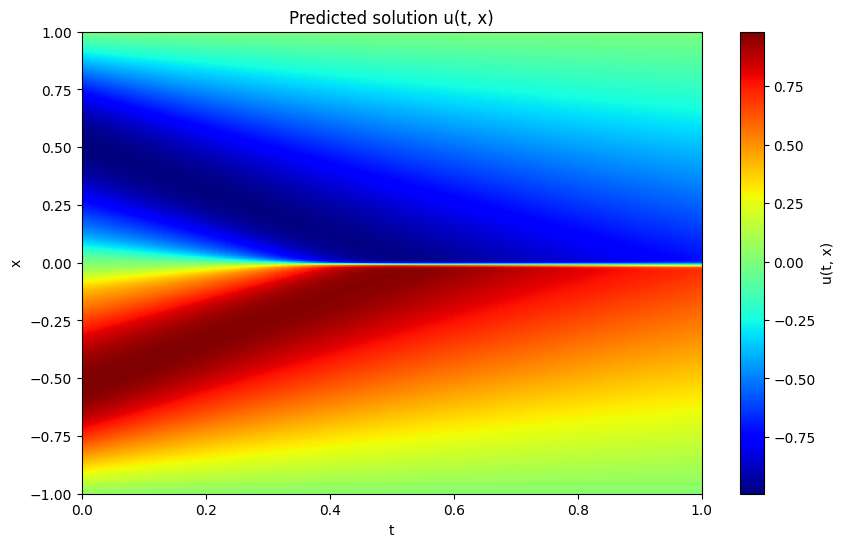

In [15]:
# Main execution
if __name__ == "__main__":
    layers = [50, 50, 50, 50]
    model = PINN(layers)

    t_u, x_u, u, t_boundary, x_left, x_right, u_left, u_right, t_f, x_f = create_training_data()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train(model, optimizer, t_u, x_u, u, t_f, x_f, epochs=5000)
    plot_results(model)